In [ ]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip

--2021-07-15 20:15:51--  https://zenodo.org/record/4498364/files/public_dataset.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip’

public_dataset.zip  100%[===================>]   1.24G  8.22MB/s    in 88s     

2021-07-15 20:17:20 (14.5 MB/s) - ‘public_dataset.zip’ saved [1332806163/1332806163]



In [ ]:
!unzip public_dataset.zip
!pip install audiosegment
!pip install tensorflow-io
!pip install pydub

In [ ]:
import json
import pandas as pd
from pydub import AudioSegment
import tqdm
import os
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
directory = 'public_dataset'
k = []
def read_json(x, audios):
    with open(x, 'r') as j:
        d= json.load(j)
 
        d['audioName'] = audios
        return d
 
datas = []
audios = None
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if f.endswith('json'):
        datas.append(read_json(f, audios))
 
    else:
        audios = f
    
 
df = pd.DataFrame(datas,)

In [ ]:
df.info()
del datas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   datetime               27550 non-null  object
 1   cough_detected         27550 non-null  object
 2   audioName              27550 non-null  object
 3   latitude               16084 non-null  object
 4   longitude              16084 non-null  object
 5   age                    15218 non-null  object
 6   gender                 16224 non-null  object
 7   respiratory_condition  16224 non-null  object
 8   fever_muscle_pain      16224 non-null  object
 9   status                 16224 non-null  object
 10  expert_labels_2        820 non-null    object
 11  expert_labels_3        820 non-null    object
 12  expert_labels_4        820 non-null    object
 13  expert_labels_1        820 non-null    object
dtypes: object(14)
memory usage: 2.9+ MB


In [ ]:
dropdf = df.drop(columns=['datetime','latitude','longitude', 'expert_labels_4', 'expert_labels_3','expert_labels_2','expert_labels_1'])

In [ ]:
noNulldf = dropdf.dropna(axis=0)
noNulldf

,cough_detected,audioName,age,gender,respiratory_condition,fever_muscle_pain,status
1,0.9901,public_dataset/ba1ce016-b24d-434a-99b6-b93117d...,33,male,False,False,healthy
3,0.9847,public_dataset/ba1ce016-b24d-434a-99b6-b93117d...,31,male,False,False,healthy
4,0.9897,public_dataset/809a82a8-9bd3-4fae-82df-f296fac...,36,male,True,False,healthy
5,0.9974,public_dataset/809a82a8-9bd3-4fae-82df-f296fac...,18,male,False,False,healthy
9,0.9961,public_dataset/84b39e54-1788-4b16-875f-6696701...,24,female,False,False,healthy
...,...,...,...,...,...,...,...
27542,0.9844,public_dataset/56a4e179-3a06-42f2-b029-1924db4...,45,male,False,False,healthy
27544,0.8558,public_dataset/56a4e179-3a06-42f2-b029-1924db4...,20,male,False,False,healthy
27545,0.9620,public_dataset/10c2cd2a-d467-4535-8b63-f8cf820...,31,male,False,False,symptomatic
27546,0.4848,public_dataset/6d45e866-26cd-4c90-b538-8e3d746...,23,male,False,False,symptomatic


In [ ]:
noNulldf.status.unique()

array(['healthy', 'COVID-19', 'symptomatic'], dtype=object)

In [ ]:
# convert false / true to 0/1
ft_map = {'False' : 0, 'True': 1}
status_map = {
    'healthy':0,
    'COVID-19':1,
    'symptomatic':2
}
gender_map = {'male' : 0, 'female' :1}
# considering 
noNulldf.respiratory_condition = noNulldf.respiratory_condition.map(ft_map)
noNulldf.fever_muscle_pain = noNulldf.fever_muscle_pain.map(ft_map)
noNulldf.status = noNulldf.status.map(status_map)
noNulldf.gender = noNulldf.gender.map(gender_map)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
noNulldf

,cough_detected,audioName,age,gender,respiratory_condition,fever_muscle_pain,status
1,0.9901,public_dataset/ba1ce016-b24d-434a-99b6-b93117d...,33,0.0,0,0,0
3,0.9847,public_dataset/ba1ce016-b24d-434a-99b6-b93117d...,31,0.0,0,0,0
4,0.9897,public_dataset/809a82a8-9bd3-4fae-82df-f296fac...,36,0.0,1,0,0
5,0.9974,public_dataset/809a82a8-9bd3-4fae-82df-f296fac...,18,0.0,0,0,0
9,0.9961,public_dataset/84b39e54-1788-4b16-875f-6696701...,24,1.0,0,0,0
...,...,...,...,...,...,...,...
27542,0.9844,public_dataset/56a4e179-3a06-42f2-b029-1924db4...,45,0.0,0,0,0
27544,0.8558,public_dataset/56a4e179-3a06-42f2-b029-1924db4...,20,0.0,0,0,0
27545,0.9620,public_dataset/10c2cd2a-d467-4535-8b63-f8cf820...,31,0.0,0,0,2
27546,0.4848,public_dataset/6d45e866-26cd-4c90-b538-8e3d746...,23,0.0,0,0,2


In [ ]:
import keras.layers as layers
import keras.models as models

In [ ]:
class covid_net(models.Model):
    def __init__(self):
        super(covid_net, self).__init__()
 
        
        self.cnn2dModel = models.Sequential([
                                             
                                             layers.Conv2D(4, 5, 3, activation='relu'),
                                             layers.MaxPooling2D(),
                                             layers.Dropout(0.2),
                                             layers.Conv2D(10, 3, 2, activation='relu'),
                                             layers.MaxPooling2D(),
                                             layers.Conv2D(40, 3, 1, activation='relu'),
                                             layers.MaxPooling2D(),
                                             layers.Dropout(0.2),
                                             layers.Flatten()
        ])
        
        self.cnnmodel = models.Sequential([
                                            
                                            layers.Conv1D(50, 30, 15, activation='relu'),
                                            layers.MaxPooling1D(),
                                            layers.Dropout(0.2),
                                            layers.Conv1D(100, 20, 5, activation='relu'),
                                            layers.MaxPooling1D(),
                                            layers.BatchNormalization(),  
                                            layers.LSTM(150, return_sequences=True),
                                            layers.Dropout(0.2),
                                            layers.Flatten()
 
        ])
        
        self.output_layer = models.Sequential([
                                                                                           
                                                
                                                layers.Dense(128, activation='relu'),
                                                layers.Dropout(0.3),
                                                layers.Dense(128, activation='relu'),
                                                layers.Dense(3,activation='softmax')])
        
    def call(self, inps):
        audio, infos, spectos = inps
        spectox = self.cnn2dModel(spectos)
        audiox = self.cnnmodel(audio)
        x = layers.Concatenate(axis=1)([audiox, infos, spectox])
        
        return self.output_layer(x)
model = covid_net()

# Handling Data Imbalance

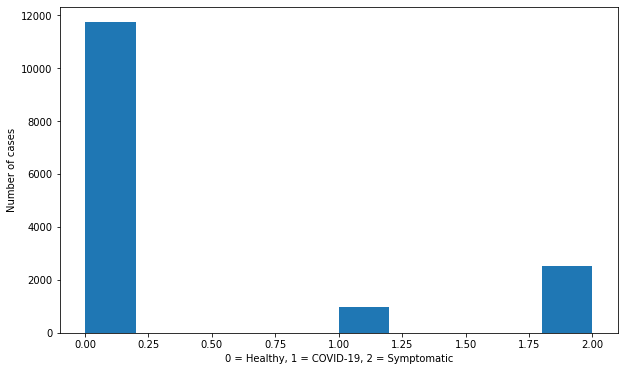

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.hist(noNulldf['status'])
plt.ylabel('Number of cases')
plt.xlabel('0 = Healthy, 1 = COVID-19, 2 = Symptomatic')
plt.show()

In [ ]:
# OVERSAMPLING
classes_zero = noNulldf[noNulldf['status'] == 0]
classes_one = noNulldf[noNulldf['status'] == 1]
classes_two = noNulldf[noNulldf['status'] == 2]
 
num_samples_class = 1500
 
print(f'Class 0: {len(classes_zero)}')
print(f'Class 1: {len(classes_one)}')
print(f'Class 1: {len(classes_two)}')
 
classes_zero = classes_zero.sample(num_samples_class, replace=True)
classes_one = classes_one.sample(num_samples_class, replace=True)
classes_two = classes_two.sample(num_samples_class, replace=True)
 
print("AFTER OVERSAMPLING")
print(f'Class 0: {len(classes_zero)}')
print(f'Class 1: {len(classes_one)}')
print(f'Class 1: {len(classes_two)}')

Class 0: 11732
Class 1: 965
Class 1: 2521
AFTER OVERSAMPLING
Class 0: 1500
Class 1: 1500
Class 1: 1500


In [ ]:
oversampled_df = pd.concat([classes_zero,classes_one, classes_two], ignore_index=True).sample(frac=1, random_state=0)
oversampled_df

,cough_detected,audioName,age,gender,respiratory_condition,fever_muscle_pain,status
854,0.2800,public_dataset/bd720b02-352c-497c-a23c-e4dc654...,55,0.0,0,0,0
2560,0.9944,public_dataset/52ba6875-b680-44e8-8ca2-eecb5a7...,20,0.0,0,0,1
2212,0.9777,public_dataset/89a9ccc6-5055-484f-b038-6b16bc1...,15,0.0,1,1,1
2347,0.9852,public_dataset/ace55ed0-37fb-4f08-bbc4-997092a...,32,0.0,0,0,1
1529,0.9292,public_dataset/123e6c0d-3d35-4978-b1b9-24b8498...,25,0.0,0,0,1
...,...,...,...,...,...,...,...
1033,0.2391,public_dataset/9c6bb0e7-c890-457d-bf68-744d9c1...,18,0.0,0,0,0
3264,0.9629,public_dataset/bf1b9f1b-84c4-45f3-973a-9fee12f...,43,1.0,1,0,2
1653,0.2417,public_dataset/11982ef5-3cd7-4dbf-90a4-6fcd778...,50,0.0,0,0,1
2607,0.1290,public_dataset/cfc5e6f0-954a-47af-854d-8a48681...,45,1.0,1,1,1


In [ ]:
del df

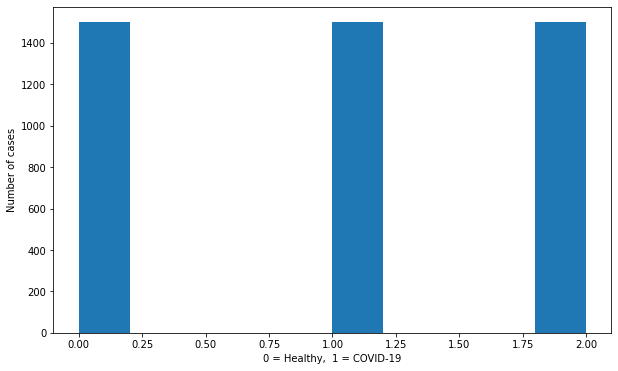

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.hist(oversampled_df['status'], )
plt.ylabel('Number of cases')
plt.xlabel('0 = Healthy,  1 = COVID-19')
plt.show()

In [ ]:
import tensorflow_io as tfio
audios = []
 
 
for i in tqdm.tqdm(oversampled_df['audioName']):
    segment = AudioSegment.from_file(i).set_frame_rate(15000)
    arr = np.array(segment.get_array_of_samples(), dtype=np.float32)
    if np.max(arr) == 0:
        continue
    arr = arr/np.max(arr)
    
    pos = tfio.audio.trim(tf.constant(arr), axis=0, epsilon=0.2)
    audios.append(arr[pos[0]:pos[1]])
 
padded_seq = pad_sequences(audios, dtype='float32', padding='post', maxlen=250000)  
padded_seq = tf.reshape(padded_seq, (-1, 250000,1 ))

100%|██████████| 4500/4500 [18:46<00:00,  4.00it/s]


In [ ]:
x = np.array(oversampled_df[['cough_detected', 'respiratory_condition', 'fever_muscle_pain', 'gender', 'age']])
labels = np.reshape(np.array(oversampled_df.status), (-1, 1))
info = tf.constant(x, dtype=tf.float32)

In [ ]:
del audios

100%|██████████| 4498/4498 [02:36<00:00, 28.83it/s]


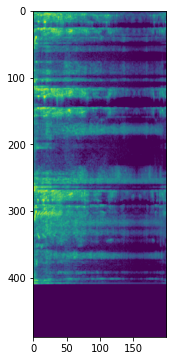

In [ ]:
# Mel Spectograms
import librosa
def preprocess_audio_mel_T(audio, sample_rate=15000,  n_mels=200):

    audio = tf.squeeze(audio).numpy()
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40)/40

    return mel_db.T
specs = []
for i in tqdm.tqdm(padded_seq):
    specs.append(tf.constant(preprocess_audio_mel_T(i)))
plt.imshow(specs[-1])

In [ ]:
specs[-1].shape

TensorShape([489, 200])

In [ ]:
for i in range(len(specs)):
    specs[i] = np.reshape(specs[i], (*specs[-1].shape, 1))


In [ ]:
specTensor = tf.constant(np.array(specs))
del specs
specTensor.shape

TensorShape([4498, 489, 200, 1])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
metric = 'val_accuracy'
c = tf.keras.callbacks.ModelCheckpoint(filepath="ModelWeights/bestAcc", monitor=metric,
                    verbose=2, save_best_only=True, mode='max')

In [ ]:
history = model.fit((padded_seq, info, specTensor), labels, epochs=10, validation_split=0.2, callbacks = [c])

In [ ]:
plt.plot(history.history['val_loss'])